<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/CNN_for_Multiple_Noise_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# CAP-345-3 - Inteligência Artificial

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)
* Luis Ricardo Arantes Filho
* Rubens Sautter

## Modelo simples de classificação de tipo de ruido em imagens

Gerador de Ruidos: 
An parameter of correction has been used (s):

$$
FFT(f(w)) = \text{gauss}(0,\sigma) * (1/w^\beta)^{(\beta s/2) }
$$

Frequencies are measured in multidimensional space by the frequency euclidian distance.

Parameter for all noise types
size = 128
wn = cNoise(0,(size,size),maxCorrections=100,maxAvgError=0.001, eta=0.05)

#### Coordenador: Dr. Reinaldo R. Rosa
#### National Institute for Space Research

# Generating Data Set
Here we will shotly generaty dataser

## Import Noise Function



In [ ]:
%%capture
! git clone https://github.com/rsautter/Noisy-Complex-Ginzburg-Landau.git

In [ ]:
%cd Noisy-Complex-Ginzburg-Landau/

/content/Noisy-Complex-Ginzburg-Landau


In [ ]:
#import the cNoise function
import cNoise as cNoise
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import cv2

%cd ..

/content


In [ ]:
images_for_classes = 10

#Generating several colored noise from `cNoise` mudule
#%%capture 
size = 128
noise = []
beta  = []
for j in range(0,images_for_classes):
  for i in range(0,15):
    noise.append(cNoise.cNoise(i/4,(size,size),maxCorrections=100,maxAvgError=0.001, eta=0.05))
    beta.append(i/4)
    print('data_set '+str(j)+' Noise: Beta '+str(i/4))

df_data = pd.DataFrame({'image':noise, 'class':beta})
#df_data.to_pickle('MultipleCNN_Noise.plk')


# Kagle Data set download

Here we will download a dataset from kagle, place it on google drive and then download the file. As the dataset has already been downloaded once in google drive I will just access the `.zip` file in the drive and do the `--unzip` in the home folder of google colab.

https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle/
#!kaggle datasets download -d luanorionbarana/2d-colored-noise
!unzip "2d-colored-noise.zip" -d "/content/"
%cd ..
%cd ..
%cd ..
df_data_all =  pd.read_pickle('MultipleCNN_Noise.plk')

## Ploting Data 🗓️

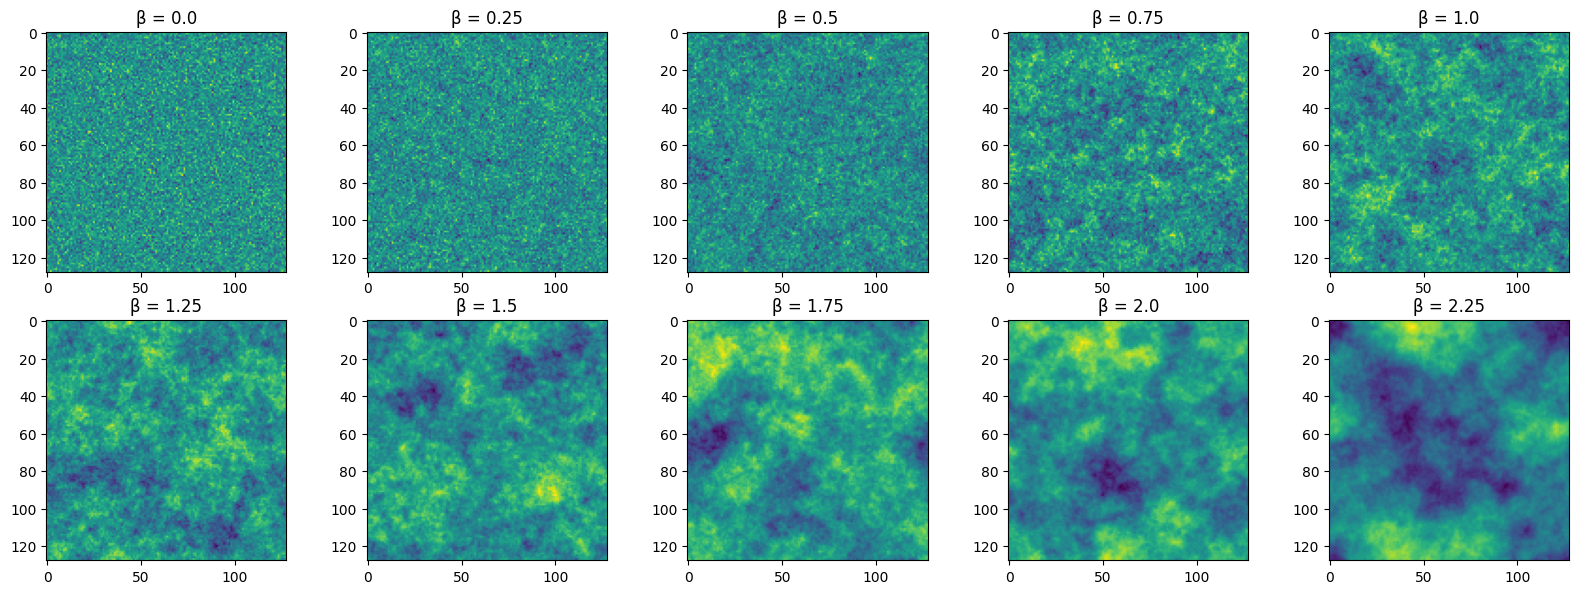

In [ ]:
#plt.figure(figsize=(20,10),dpi=50)
plt.figure(figsize=(20,7),dpi=100)
for i in range(0,10):
  plt.subplot(2,5,i+1)
  plt.title('β = '+str(df_data['class'][i]))
  plt.imshow(df_data['image'][i])


# Reading Images 

We will generate the dataset that we will use for classification in the convolutional neural network. We will use Rubens Sauter's code to generate these noises in two dimensions. We will generate 31 noise classes. And we will generate a total of 100 218x218 images per class. As this code is very time consuming, we will generate the images and host them on google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#ls
%cd drive/MyDrive/INPE/CCN_For_Noise_Classification

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/INPE/CCN_For_Noise_Classification'
/content/drive/MyDrive/INPE/CCN_For_Noise_Classification


In [ ]:
#testing changing variables
#df_rect_2 = df_rect_1
#df_rect_1 = df_data
df_rect_1 = df_data_all

# GENERATE SETS

In [ ]:
#Why save this dataframe
path_dataframe = os.getcwd() + '/Dataframes'
##Salvar esse DF       
def salvaDataFrames_pkl(dataFrame,caminhoSaida,nomeArquivo):
    dataFrame.to_pickle(caminhoSaida+'/'+nomeArquivo, compression='infer')

salvaDataFrames_pkl(df_rect_1,path_dataframe,'Data_Frame_Noise_images.pkl')

In [ ]:
#ADJUST IMG DIM
from PIL import Image
import cv2 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
image_list = []
i = 0
for i in range(len(df_rect_1)):
    #print(i)
    #old_im = cv2.imread(df_rect_1.loc[i,'image_data'])    
    gray = cv2.resize(df_rect_1.loc[i,'image'],(128,128),cv2.INTER_AREA)
    #gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY) #Whay put on gray?
    #print(gray.shape)
    image_list.append(gray)
    #print(i)

In [ ]:
#Alocating the labels for the classes
labels = np.array(df_rect_1['class'])

In [ ]:
#How diferent classes are on the labels?
from collections import Counter
n_class = len(Counter(labels).values()) # equals to list(set(words))
#https://stackoverflow.com/questions/12282232/how-do-i-count-occurrence-of-unique-values-inside-a-list
n_class

15

# Spliting traing and test data sets

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

'''
Montar Conjunto de Treinamento - Testes IMAGENS ARTIFICIAIS
'''
#Dividindo Conjunto de treinamento e de Teste
X_train, X_test, y_train, y_test = train_test_split(
    np.asarray(image_list),
    np.asarray(labels/10),
    test_size=0.20, 
    shuffle=True,
    random_state=42,
)

#Scale images to the [0, 1] range
# X_train = X_train.reshape(len(X_train),128,128,1) 
# X_test = X_test.reshape(len(X_test),128,128,1)

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
print(X_train.shape)


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, n_class)
y_test = keras.utils.to_categorical(y_test, n_class)

(12000, 128, 128)


In [ ]:
#Settings the train and test data 
path_datasets = os.getcwd() + '/Sets/'

np.save(path_datasets + 'X_train.npy', X_train)
np.save(path_datasets + 'X_test.npy', X_test)
np.save(path_datasets + 'y_train.npy', y_train)
np.save(path_datasets + 'y_test.npy', y_test)

In [ ]:
## TRAINING STEP
path_model = os.getcwd() + '/Model/'

# CNN Model

In [ ]:
'''
# =============================================================================
# NEURAL MODEL - CONVOLUTIONAL NEURAL NETWORK - SIMPLE - RETURNS POINTS (X,Y)
# =============================================================================
'''
from keras import layers
from keras import models
from keras import optimizers
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
#from keras.models import Sequential
from tensorflow.keras.models import Sequential
#from keras.utils import multi_gpu_model
#from tensorflow.keras.utils import multi_gpu_model

'''
# =============================================================================
# TESTANDO OUTRAS ABORDAGENS -- O MELHOR MODELO - TEST 1
#=============================================================================
'''
model = keras.Sequential(
    [
        keras.Input(shape=(128,128,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(n_class, activation="softmax"),
    ]
)

model.summary()

batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_split=0.1)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_mse:', test_acc)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 57600)             0         
                                                                 
 dropout_13 (Dropout)        (None, 57600)           

In [ ]:
def salvarmodelo(nome,modelo):
    #Salvando
    filename = nome+'.sav'
    pickle.dump(modelo, open(filename, 'wb'))
    

def salvardicionario(nome, history):
    #Salvando Dicionario
    w = csv.writer(open(nome+".csv", "w"))
    for key, val in history.items():
        w.writerow([key, val])    
        
#Estatisticas do modelo
#cria dicionario
history_dict = history.history
history_dict.keys()
#Salvando Dicionario
salvardicionario(path_model+"History_noise_class",history_dict)
model.save(path_model+"Cnn_model_noise_class.h5")

In [ ]:
## VERIFY STATS AND TRAINING
def abreDataFrame(caminho,nomeArq):
    dataFrame = pd.read_pickle(caminho + nomeArq)#READ PICKLE MUITO IMPORTANTE!!!!!
    return dataFrame

def abreDataFramecsv(caminho,nomeArq):
    dataFrame = pd.read_csv(caminho + nomeArq,names=['Metrics','Values'])#READ PICKLE MUITO IMPORTANTE!!!!!
    return dataFrame


# Avaliating Model

In [ ]:
#ConvNet_1D_ARQ1_MULTIFILTRO
nome_History = 'History_noise_class.csv'
nome_Model = "Cnn_model_noise_class.h5"

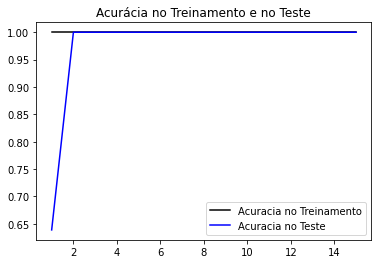

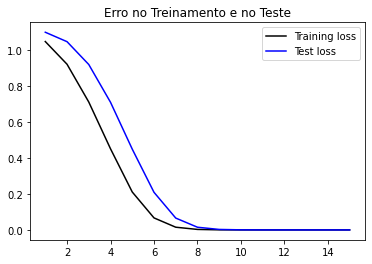

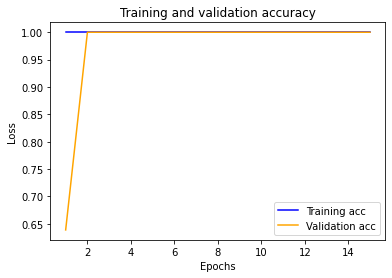

In [ ]:
'''
Plotando as Curvas de Validação e de Erro - Aprendizado do Modelo
'''
history = abreDataFramecsv(path_model, nome_History)
#history = history.to_dict()
acc = history.loc[3,'Values']
val_acc = history.loc[1,'Values']
loss = history.loc[2,'Values']
val_loss = history.loc[0,'Values']

from ast import literal_eval

acc = literal_eval(acc)
val_acc = literal_eval(val_acc)
loss = literal_eval(loss)
val_loss = literal_eval(val_loss)


epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,'k', label='Acuracia no Treinamento')
plt.plot(epochs, val_acc, 'b', label='Acuracia no Teste')
plt.title('Acurácia no Treinamento e no Teste')
plt.legend()
plt.figure()
plt.plot(epochs, loss,'k', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Erro no Treinamento e no Teste')
plt.legend()
plt.show()
 
plt.figure()
acc_values = acc
val_acc_values = val_acc
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc_values, 'orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
'''
# =============================================================================
# COMPUTANDO ESTATISTICAS
# =============================================================================
'''
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import validation_curve

def computaStats_Classification(modelo,nome,X_a,y_a):
    print("Estatisticas do Modelo - "+nome)
    #predição
    y_pred = modelo.predict([X_a])
    y_true = y_a
    #Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    #Convert validation observations to one hot vectors
    Y_true = np.argmax(y_a,axis = 1) 
    #MEAN SQUARE ERROR
    
    print("Erro medio quadratico: ", mean_squared_error(Y_true, Y_pred_classes))
    
    #Acurácia
    print("Acuracia: ", accuracy_score(Y_true, Y_pred_classes))
    
    #Precisão
    print("Precisao: ", precision_score(Y_true, Y_pred_classes,average=None))
    
    #Recall
    print("Recall: ", recall_score(Y_true, Y_pred_classes,average=None))
    
    #F1 - Score
    print("F1 -Score: ", f1_score(Y_true, Y_pred_classes,average=None))
    

computaStats_Classification(model,'ConvNet_Noise_Class - Treino',X_train,y_train)
# print("--------**********-------------***********---------------**************")
computaStats_Classification(model,'ConvNet_Noise_Class - Testes',X_test,y_test)

Estatisticas do Modelo - ConvNet_Noise_Class - Treino
Erro medio quadratico:  0.0
Acuracia:  1.0
Precisao:  [1.]
Recall:  [1.]
F1 -Score:  [1.]
Estatisticas do Modelo - ConvNet_Noise_Class - Testes
Erro medio quadratico:  0.0
Acuracia:  1.0
Precisao:  [1.]
Recall:  [1.]
F1 -Score:  [1.]


In [128]:
from google.colab import drive
drive.mount('/content/drive')

import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle/
#!kaggle datasets download -d luanorionbarana/2d-colored-noise
!unzip "2d-colored-noise.zip" -d "/content/"
%cd ..
%cd ..
%cd ..
df_data_all =  pd.read_pickle('MultipleCNN_Noise.plk')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle
Archive:  2d-colored-noise.zip
  inflating: /content/MultipleCNN_Noise.plk  
/content/drive/MyDrive
/content/drive
/content
